# Feed-Forward MLP for HIGGS Classification

In [3]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')

Using device: cpu
PyTorch version: 2.9.1


In [ ]:
def load_higgs_data(train_path, val_path, test_path):
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    # Separate features and labels
    X_train = train_df.drop('label', axis=1).values
    y_train = train_df['label'].values
    
    X_val = val_df.drop('label', axis=1).values
    y_val = val_df['label'].values
    
    X_test = test_df.drop('label', axis=1).values
    y_test = test_df['label'].values
    
    # Standardize features (fit on training set only)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training label distribution: {np.bincount(y_train.astype(int))}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

# Load data
X_train, y_train, X_val, y_val, X_test, y_test, scaler = load_higgs_data(
    '../data/samples/higgs_train.csv',
    '../data/samples/higgs_val.csv',
    '../data/samples/higgs_test.csv'
)

Training set: 400000 samples, 28 features
Validation set: 50000 samples
Test set: 50000 samples
Training label distribution: [188484 211516]


In [ ]:
class MLP(nn.Module):

    def __init__(self, input_dim, hidden_size, depth):
        super(MLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.depth = depth
        
        # Build layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(nn.Tanh())
        
        # Hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        
        # Output layer
        layers.append(nn.Linear(hidden_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def __repr__(self):
        return f"MLP(input_dim={self.input_dim}, hidden_size={self.hidden_size}, depth={self.depth})"

# Test instantiation
test_model = MLP(input_dim=28, hidden_size=300, depth=5)
print(test_model)
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters()):,}")

MLP(input_dim=28, hidden_size=300, depth=5)

Total parameters: 370,201


In [ ]:
def evaluate_auc(model, X, y, device, batch_size=1024):

    model.eval()
    predictions = []
    
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch_X = torch.FloatTensor(X[i:i+batch_size]).to(device)
            batch_pred = model(batch_X).cpu().numpy().flatten()
            predictions.extend(batch_pred)
    
    auc = roc_auc_score(y, predictions)
    return auc


def train_mlp(model, X_train, y_train, X_val, y_val, 
              learning_rate=0.01, weight_decay=0.0, 
              batch_size=128, max_epochs=100, patience=10, 
              device='cpu', verbose=True):
    model = model.to(device)
    
    # SGD with momentum (momentum=0.9 is standard)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                         momentum=0.9, weight_decay=weight_decay)
    
    # Binary Cross-Entropy loss
    criterion = nn.BCELoss()
    
    # Prepare data loaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train).unsqueeze(1)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Training history
    history = {
        'train_loss': [],
        'val_auc': [],
        'epoch': []
    }
    
    best_val_auc = 0.0
    best_epoch = 0
    best_model_state = None
    epochs_without_improvement = 0
    
    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        train_loss /= len(X_train)
        
        # Validation phase
        val_auc = evaluate_auc(model, X_val, y_val, device)
        
        history['train_loss'].append(train_loss)
        history['val_auc'].append(val_auc)
        history['epoch'].append(epoch + 1)
        
        # Early stopping check
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_epoch = epoch + 1
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:3d}/{max_epochs} | Loss: {train_loss:.4f} | "
                  f"Val AUC: {val_auc:.4f} | Best: {best_val_auc:.4f} (epoch {best_epoch})")
        
        # Early stopping
        if epochs_without_improvement >= patience:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Restore best model
    model.load_state_dict(best_model_state)
    
    if verbose:
        print(f"\nTraining completed. Best validation AUC: {best_val_auc:.4f} at epoch {best_epoch}")
    
    return {
        'model': model,
        'best_val_auc': best_val_auc,
        'best_epoch': best_epoch,
        'history': history
    }

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


In [8]:
from itertools import product

# Hyperparameter grid (from the paper)
hyperparameter_grid = {
    'depth': [2, 3, 4, 5, 6],
    'hidden_size': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05],
    'weight_decay': [0.0, 1e-5]
}

# Generate all combinations
all_configs = []
for depth, hidden_size, lr, wd in product(
    hyperparameter_grid['depth'],
    hyperparameter_grid['hidden_size'],
    hyperparameter_grid['learning_rate'],
    hyperparameter_grid['weight_decay']
):
    all_configs.append({
        'depth': depth,
        'hidden_size': hidden_size,
        'learning_rate': lr,
        'weight_decay': wd
    })

print(f"Total hyperparameter configurations: {len(all_configs)}")
print(f"\nConfigurations:")
for i, config in enumerate(all_configs[:]):
    print(f"{i+1}. {config}")

Total hyperparameter configurations: 80

Configurations:
1. {'depth': 2, 'hidden_size': 100, 'learning_rate': 0.01, 'weight_decay': 0.0}
2. {'depth': 2, 'hidden_size': 100, 'learning_rate': 0.01, 'weight_decay': 1e-05}
3. {'depth': 2, 'hidden_size': 100, 'learning_rate': 0.05, 'weight_decay': 0.0}
4. {'depth': 2, 'hidden_size': 100, 'learning_rate': 0.05, 'weight_decay': 1e-05}
5. {'depth': 2, 'hidden_size': 200, 'learning_rate': 0.01, 'weight_decay': 0.0}
6. {'depth': 2, 'hidden_size': 200, 'learning_rate': 0.01, 'weight_decay': 1e-05}
7. {'depth': 2, 'hidden_size': 200, 'learning_rate': 0.05, 'weight_decay': 0.0}
8. {'depth': 2, 'hidden_size': 200, 'learning_rate': 0.05, 'weight_decay': 1e-05}
9. {'depth': 2, 'hidden_size': 300, 'learning_rate': 0.01, 'weight_decay': 0.0}
10. {'depth': 2, 'hidden_size': 300, 'learning_rate': 0.01, 'weight_decay': 1e-05}
11. {'depth': 2, 'hidden_size': 300, 'learning_rate': 0.05, 'weight_decay': 0.0}
12. {'depth': 2, 'hidden_size': 300, 'learning_rate

In [ ]:
def hyperparameter_search(X_train, y_train, X_val, y_val, configs, 
                          device='cpu', batch_size=128, max_epochs=50, 
                          patience=7, n_configs=None):
    input_dim = X_train.shape[1]
    results = []
    
    # Optionally sample configurations
    if n_configs is not None and n_configs < len(configs):
        configs = np.random.choice(configs, size=n_configs, replace=False).tolist()
        print(f"Sampling {n_configs} random configurations out of {len(configs)}")
    
    print(f"Starting hyperparameter search over {len(configs)} configurations...")
    print("=" * 80)
    
    for i, config in enumerate(configs):
        print(f"\nConfiguration {i+1}/{len(configs)}")
        print(f"Depth: {config['depth']}, Hidden: {config['hidden_size']}, "
              f"LR: {config['learning_rate']}, WD: {config['weight_decay']}")
        
        # Create model
        model = MLP(input_dim=input_dim, 
                   hidden_size=config['hidden_size'], 
                   depth=config['depth'])
        
        # Train model
        result = train_mlp(
            model, X_train, y_train, X_val, y_val,
            learning_rate=config['learning_rate'],
            weight_decay=config['weight_decay'],
            batch_size=batch_size,
            max_epochs=max_epochs,
            patience=patience,
            device=device,
            verbose=False
        )
        
        # Store results
        results.append({
            'depth': config['depth'],
            'hidden_size': config['hidden_size'],
            'learning_rate': config['learning_rate'],
            'weight_decay': config['weight_decay'],
            'val_auc': result['best_val_auc'],
            'best_epoch': result['best_epoch'],
            'model': result['model']
        })
        
        print(f"  → Validation AUC: {result['best_val_auc']:.4f} (epoch {result['best_epoch']})")
    
    print("\n" + "=" * 80)
    print("Hyperparameter search completed!")
    
    # Create DataFrame
    results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} 
                               for r in results])
    
    # Sort by validation AUC
    results_df = results_df.sort_values('val_auc', ascending=False).reset_index(drop=True)
    
    return results_df, results



Hyperparameter search function defined.


In [ ]:
import time

# Configuration for search
BATCH_SIZE = 256
MAX_EPOCHS = 200
PATIENCE = 7 
N_CONFIGS = None

start_time = time.time()

results_df, results_list = hyperparameter_search(
    X_train, y_train, X_val, y_val,
    configs=all_configs,
    device=device,
    batch_size=BATCH_SIZE,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    n_configs=N_CONFIGS
)

elapsed_time = time.time() - start_time
print(f"\nTotal search time: {elapsed_time/60:.1f} minutes")

print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS BY VALIDATION AUC")
print("="*80)
print(results_df.head(10).to_string(index=False))

best_config_idx = results_df.index[0]
best_config = results_df.iloc[0].to_dict()
best_model = results_list[best_config_idx]['model']

print(f"\n{'='*80}")
print("BEST CONFIGURATION:")
print(f"{'='*80}")
print(f"Depth: {best_config['depth']}")
print(f"Hidden size: {best_config['hidden_size']}")
print(f"Learning rate: {best_config['learning_rate']}")
print(f"Weight decay: {best_config['weight_decay']}")
print(f"Validation AUC: {best_config['val_auc']:.4f}")
print(f"Best epoch: {best_config['best_epoch']}")

Starting hyperparameter search over 80 configurations...

Configuration 1/80
Depth: 2, Hidden: 100, LR: 0.01, WD: 0.0
  → Validation AUC: 0.8226 (epoch 47)

Configuration 2/80
Depth: 2, Hidden: 100, LR: 0.01, WD: 1e-05
  → Validation AUC: 0.8226 (epoch 47)

Configuration 2/80
Depth: 2, Hidden: 100, LR: 0.01, WD: 1e-05
  → Validation AUC: 0.8224 (epoch 49)

Configuration 3/80
Depth: 2, Hidden: 100, LR: 0.05, WD: 0.0
  → Validation AUC: 0.8224 (epoch 49)

Configuration 3/80
Depth: 2, Hidden: 100, LR: 0.05, WD: 0.0
  → Validation AUC: 0.8220 (epoch 26)

Configuration 4/80
Depth: 2, Hidden: 100, LR: 0.05, WD: 1e-05
  → Validation AUC: 0.8220 (epoch 26)

Configuration 4/80
Depth: 2, Hidden: 100, LR: 0.05, WD: 1e-05
  → Validation AUC: 0.8228 (epoch 35)

Configuration 5/80
Depth: 2, Hidden: 200, LR: 0.01, WD: 0.0
  → Validation AUC: 0.8228 (epoch 35)

Configuration 5/80
Depth: 2, Hidden: 200, LR: 0.01, WD: 0.0
  → Validation AUC: 0.8240 (epoch 41)

Configuration 6/80
Depth: 2, Hidden: 200, L

FINAL TEST SET EVALUATION
Best Model Configuration:
  - Depth: 5.0
  - Hidden size: 200.0
  - Learning rate: 0.01
  - Weight decay: 1e-05

Performance:
  - Validation AUC: 0.8302
  - Test AUC: 0.8214


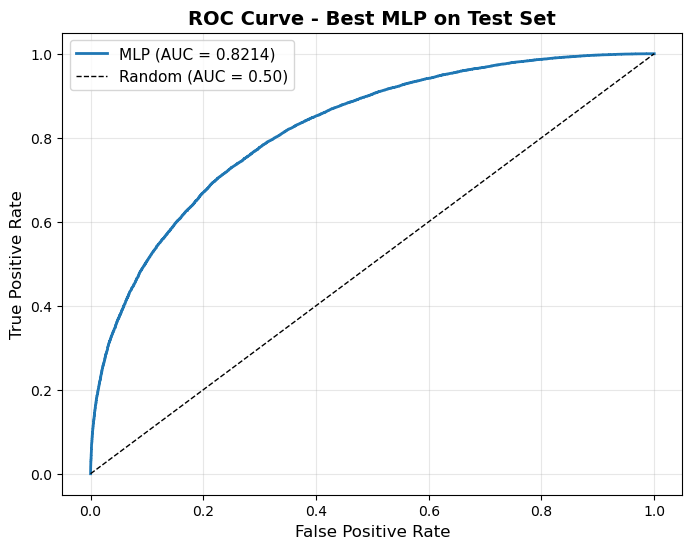

In [ ]:
test_auc = evaluate_auc(best_model, X_test, y_test, device)

print("="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)
print(f"Best Model Configuration:")
print(f"  - Depth: {best_config['depth']}")
print(f"  - Hidden size: {best_config['hidden_size']}")
print(f"  - Learning rate: {best_config['learning_rate']}")
print(f"  - Weight decay: {best_config['weight_decay']}")
print(f"\nPerformance:")
print(f"  - Validation AUC: {best_config['val_auc']:.4f}")
print(f"  - Test AUC: {test_auc:.4f}")
print("="*80)

# Get predictions for ROC curve
best_model.eval()
with torch.no_grad():
    test_preds = []
    for i in range(0, len(X_test), 1024):
        batch_X = torch.FloatTensor(X_test[i:i+1024]).to(device)
        batch_pred = best_model(batch_X).cpu().numpy().flatten()
        test_preds.extend(batch_pred)
    test_preds = np.array(test_preds)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'MLP (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Best MLP on Test Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()


COMPARATIVE ANALYSIS: MODEL PERFORMANCE
                    Model Training Samples  Test AUC                   Notes
      Logistic Regression             400K      0.69         Linear baseline
   Gradient Boosted Trees             400K      0.83     Non-linear ensemble
           MLP (Our Best)             400K  0.821356 Depth=5.0, Hidden=200.0
MLP (Paper - 10M samples)             ~10M     ~0.88        With pretraining


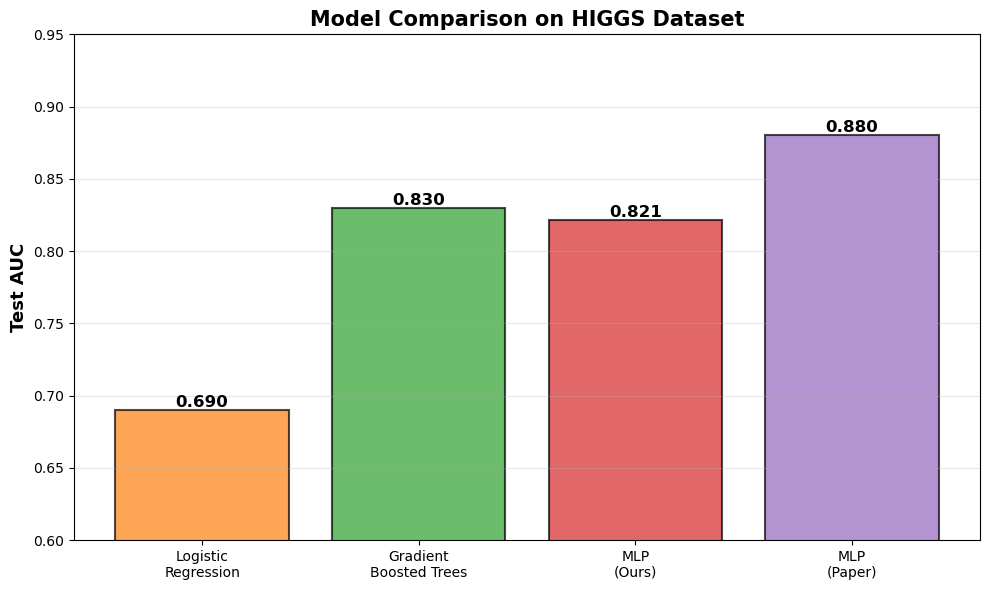


Comparison plot saved.


In [ ]:
comparison_data = {
    'Model': [
        'Logistic Regression',
        'Gradient Boosted Trees',
        'MLP (Our Best)',
        'MLP (Paper - 10M samples)'
    ],
    'Training Samples': [
        '400K',
        '400K',
        '400K',
        '~10M'
    ],
    'Test AUC': [
        0.69,
        0.83,
        test_auc,
        '~0.88'  # Approximate from paper
    ],
    'Notes': [
        'Linear baseline',
        'Non-linear ensemble',
        f'Depth={best_config["depth"]}, Hidden={best_config["hidden_size"]}',
        'With pretraining'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARATIVE ANALYSIS: MODEL PERFORMANCE")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Logistic\nRegression', 'Gradient\nBoosted Trees', 'MLP\n(Ours)', 'MLP\n(Paper)']
aucs = [0.69, 0.83, test_auc, 0.88]
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bars = ax.bar(models, aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, auc in zip(bars, aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{auc:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Test AUC', fontsize=13, fontweight='bold')
ax.set_title('Model Comparison on HIGGS Dataset', fontsize=15, fontweight='bold')
ax.set_ylim([0.6, 0.95])
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random')

plt.tight_layout()
plt.show()